<a href="https://colab.research.google.com/github/EdwinZhanCN/Projects-in-ML-and-AI/blob/main/homework_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dataset Selection

For this assignment, I will use the dataset Default to Credient Clients.

I want to implement a neural network that performs binary classification to check if the cardholder will default on their credit card in next month.

In [51]:
%pip install numpy pandas ucimlrepo

### Loading Dataset

In [52]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
default_of_credit_card_clients = fetch_ucirepo(id=350)

# data (as pandas dataframes)
X = default_of_credit_card_clients.data.features
y = default_of_credit_card_clients.data.targets

# metadata
print(default_of_credit_card_clients.metadata)

# variable information
print(default_of_credit_card_clients.variables)

{'uci_id': 350, 'name': 'Default of Credit Card Clients', 'repository_url': 'https://archive.ics.uci.edu/dataset/350/default+of+credit+card+clients', 'data_url': 'https://archive.ics.uci.edu/static/public/350/data.csv', 'abstract': "This research aimed at the case of customers' default payments in Taiwan and compares the predictive accuracy of probability of default among six data mining methods.", 'area': 'Business', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 30000, 'num_features': 23, 'feature_types': ['Integer', 'Real'], 'demographics': ['Sex', 'Education Level', 'Marital Status', 'Age'], 'target_col': ['Y'], 'index_col': ['ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2009, 'last_updated': 'Fri Mar 29 2024', 'dataset_doi': '10.24432/C55S3H', 'creators': ['I-Cheng Yeh'], 'intro_paper': {'ID': 365, 'type': 'NATIVE', 'title': 'The comparisons of data mining techniques for the predictive accuracy of 

## Part 1: Neural Network Implementation From Scratch

In [53]:
import numpy as np
import pandas as pd

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

def relu_derivative(x):
    x[x <= 0] = 0
    x[x > 0] = 1
    return x

class NeuralNetwork:
    def __init__(self, layers_dims):
        self.parameters = {}
        self.layers_dims = layers_dims
        L = len(layers_dims) # Network Layers, including input layer

        for l in range(1, L):
            # initialize Weights
            self.parameters['W' + str(l)] = np.random.randn(layers_dims[l], layers_dims[l-1]) * 0.01

            # initialize bias
            self.parameters['b' + str(l)] = np.zeros((layers_dims[l], 1))

        print(f"Initialize complete. Network: {self.layers_dims}")

    def forward_propagation(self, X):

        W1 = self.parameters['W1']
        b1 = self.parameters['b1']
        W2 = self.parameters['W2']
        b2 = self.parameters['b2']

        # First Layer
        Z1 = np.dot(W1, X) + b1
        A1 = relu(Z1)

        # Second Layer
        Z2 = np.dot(W2, A1) + b2
        A2 = sigmoid(Z2)

        # check if shape is expected.
        assert(A2.shape == (1, X.shape[1]))

        cache = {
            'Z1': Z1,
            'A1': A1,
            'Z2': Z2,
            'A2': A2
        }

        return A2, cache

    def backward_propagation(self, X, Y, cache):
        # X -- input data
        # Y -- real labels
        # cache -- get from forward propagation

        m = X.shape[1]
        (Z1, A1, W1, b1, Z2, A2, W2, b2) = (cache['Z1'], cache['A1'], self.parameters['W1'],
                                            self.parameters['b1'], cache['Z2'], cache['A2'],
                                            self.parameters['W2'], self.parameters['b2'])

        dZ2 = A2 - Y
        dW2 = (1 / m) * np.dot(dZ2, A1.T)
        db2 = (1 / m) * np.sum(dZ2, axis=1, keepdims=True)

        dZ1 = np.multiply(np.dot(W2.T, dZ2), relu_derivative(Z1))
        dW1 = (1 / m) * np.dot(dZ1, X.T)
        db1 = (1 / m) * np.sum(dZ1, axis=1, keepdims=True)

        grads = {
            "dW1": dW1,
            "db1": db1,
            "dW2": dW2,
            "db2": db2
        }

        return grads



    def compute_cost(self, AL, Y):
        # For binary classification task
        # I use Binary Cross Entropy BCE.

        # Sample number
        m = Y.shape[1]

        # Cost function
        cost = (-1 / m) * np.sum(np.multiply(Y, np.log(AL)) + np.multiply(1 - Y, np.log(1 - AL)))
        cost = np.squeeze(cost)
        print(f"Cost: {cost}")

        assert(cost.shape == ())
        return cost

    def update_parameters(self, grads, learning_rate):
        # Update parameters using gradient descent

        L = len(self.layers_dims)

        for l in range(1, L):
            self.parameters['W' + str(l)] -= learning_rate * grads['dW' + str(l)]
            self.parameters['b' + str(l)] -= learning_rate * grads['db' + str(l)]

    def train(self, X, Y, learning_rate, num_iterations):

        costs = []

        for i in range (num_iterations):
            # Forward Propagation
            AL, cache = self.forward_propagation(X)

            # Compute cost
            cost = self.compute_cost(AL, Y)

            # Backward Propagation
            grads = self.backward_propagation(X, Y, cache)

            # Update parameters
            self.update_parameters(grads, learning_rate)

            if i % 100 == 0:
                print(f"Cost after iteration {i}: {cost}")
                costs.append(cost)

        return costs

    def predict(self, X):
        A2, _ = self.forward_propagation(X)
        predictions = (A2 > 0.5).astype(int)
        return predictions

## Data cleaning, EDA

Missing value:
 0


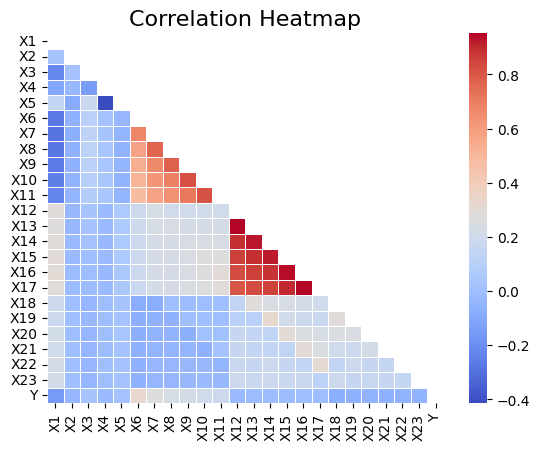

In [54]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

print ("Missing value:\n", X.isnull().sum().sum())
df = pd.concat([X, y], axis=1)

corr_matrix = df.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap', fontsize=16)
plt.show()

The above correlation heatmap shows strong correlation in History of past payments and Amount of bill statement (NT dollar). But we don't actually need to drop them, unlike regressions, neural networks utilize non-linear activation functions to effectively learn from correlated features.

And we also don't have missing value, no feature shall be dropped.

## Train-Dev-Test Split

In [55]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split test
X_temp, X_test_raw, y_temp, y_test_raw = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Split dev
X_train_raw, X_dev_raw, y_train_raw, y_dev_raw = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42
)

# Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_dev_scaled = scaler.transform(X_dev_raw)
X_test_scaled = scaler.transform(X_test_raw)

# Transpose & Reshape
X_train_final = X_train_scaled.T
X_dev_final = X_dev_scaled.T
X_test_final = X_test_scaled.T

y_train_final = y_train_raw.to_numpy().reshape(1, -1)
y_dev_final = y_dev_raw.to_numpy().reshape(1, -1)
y_test_final = y_test_raw.to_numpy().reshape(1, -1)

print("-" * 30)
print(f"Final X Train: {X_train_final.shape}")
print(f"Final X Dev:   {X_dev_final.shape}")
print(f"Final X Test:  {X_test_final.shape}")

------------------------------
Final X Train: (23, 18000)
Final X Dev:   (23, 6000)
Final X Test:  (23, 6000)


## Train

Initialize complete. Network: [23, 16, 1]
Cost: 0.6932753792993603
Cost after iteration 0: 0.6932753792993603
Cost: 0.6925020210625813
Cost: 0.691732543557296
Cost: 0.6909669277506719
Cost: 0.6902051548431573
Cost: 0.6894472051659756
Cost: 0.6886930588561396
Cost: 0.6879426968344524
Cost: 0.6871961004454629
Cost: 0.6864532498404233
Cost: 0.6857141260271002
Cost: 0.6849787097201744
Cost: 0.6842469819017684
Cost: 0.6835189240849587
Cost: 0.6827945178119819
Cost: 0.682073743641667
Cost: 0.6813565833213758
Cost: 0.6806430192325402
Cost: 0.6799330331950307
Cost: 0.679226606737054
Cost: 0.67852372141358
Cost: 0.6778243586365366
Cost: 0.6771285006312779
Cost: 0.6764361294085172
Cost: 0.6757472271885407
Cost: 0.675061776078932
Cost: 0.6743797580055941
Cost: 0.6737011557817736
Cost: 0.6730259513185829
Cost: 0.6723541276621133
Cost: 0.6716856673205679
Cost: 0.6710205531817323
Cost: 0.6703587682405251
Cost: 0.6697002952214554
Cost: 0.6690451173639895
Cost: 0.6683932175625361
Cost: 0.6677445793364

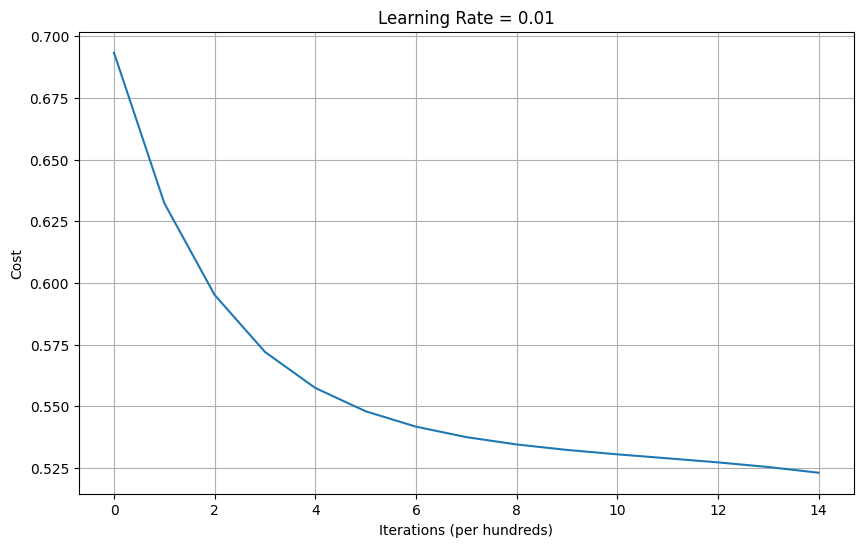

In [56]:
layer_dims = [X_train_final.shape[0], 16, 1]
net = NeuralNetwork(layer_dims)
costs = net.train(X_train_final, y_train_final, learning_rate=0.01, num_iterations=1500)

# Cost figure
plt.figure(figsize=(10, 6))
plt.plot(costs)
plt.ylabel('Cost')
plt.xlabel('Iterations (per hundreds)')
plt.title(f'Learning Rate = 0.01')
plt.grid(True)
plt.show()

## Predict on Test Data

In [57]:
predictions_test = net.predict(X_test_final)
test_accuracy = np.mean(predictions_test == y_test_final) * 100
print(f"Accuracy: {test_accuracy:.2f}%")

Accuracy: 78.12%


We can see the Gradient Descent Cost curve in figure shown above, I used the normal Gradient Descent (calculate average for all data), it still got a relatively good convergence speed. As the prediction shown in test data, the accuracy is 78.12%.

## Part 2

### Task 1

Pytorch is my selected framework

In Part1, I used Numpy for matrix operations. To implement the neural network in a framework, I need to map current data structure into APIs, this resource helps me understand Tensors, which accelrate the matrix computing.
Reource: https://docs.pytorch.org/tutorials/beginner/basics/tensorqs_tutorial.html

Another thing I learned is how to keep track of all the computations in a NN. In my past code, I manually derive and code the backward propagation gradients. And torch.autograd is a easier tool to handle this, it can automatically calculates the gradients for backpropagation.
Resource: https://docs.pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html

More would be the build in fomulations, like relu and sigmoid, or optimizer like SGD, refers to https://docs.pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html and https://docs.pytorch.org/tutorials/beginner/basics/optimization_tutorial.html.

### Task 2

In part 1, I already did EDA and train-dev-test split. So I will skip step 1 & 2.



In [58]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# transpose back for pytorch
X_train_pt = X_train_final.T
X_dev_pt   = X_dev_final.T
X_test_pt  = X_test_final.T

y_train_pt = y_train_final.T
y_dev_pt   = y_dev_final.T
y_test_pt  = y_test_final.T

# Convert to pytorch tensors
X_train_tensor = torch.tensor(X_train_pt, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_pt, dtype=torch.float32)

X_dev_tensor = torch.tensor(X_dev_pt, dtype=torch.float32)
y_dev_tensor = torch.tensor(y_dev_pt, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test_pt, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_pt, dtype=torch.float32)

print(f"shape check: {X_train_tensor.shape}")


train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

shape check: torch.Size([18000, 23])


### Step 3,4,5

- Build Model
- Define Cost Function
- Train Loop

In [59]:
import torch
import torch.nn as nn
import torch.optim as optim

class TwoLayerNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(TwoLayerNN, self).__init__()
        # ReLU is been used as non-linear layer for hidden layer
        # it is a common solution for vanishing gradient
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()

        # Sigmoid could squash the output in between 0 and 1
        # Represents probability
        self.layer2 = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.layer1(x)
        out = self.relu(out)
        out = self.layer2(out)
        out = self.sigmoid(out)
        return out


# input_dim = 23 (number of features)
# hidden_dim = 64 commonly used.
# output_dim = 1, we're doing binary calssification
model = TwoLayerNN(input_dim=23, hidden_dim=64, output_dim=1)

# Use Binary Cross Entropy for binary classification.
criterion = nn.BCELoss()

# We will use Adam, it is usually faster than normal SGD in convergence
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Epoch [100/1500], Train Loss: 0.4898, Dev Loss: 0.4857
Epoch [200/1500], Train Loss: 0.4573, Dev Loss: 0.4577
Epoch [300/1500], Train Loss: 0.4458, Dev Loss: 0.4489
Epoch [400/1500], Train Loss: 0.4392, Dev Loss: 0.4446
Epoch [500/1500], Train Loss: 0.4340, Dev Loss: 0.4420
Epoch [600/1500], Train Loss: 0.4297, Dev Loss: 0.4400
Epoch [700/1500], Train Loss: 0.4260, Dev Loss: 0.4389
Epoch [800/1500], Train Loss: 0.4230, Dev Loss: 0.4382
Epoch [900/1500], Train Loss: 0.4203, Dev Loss: 0.4376
Epoch [1000/1500], Train Loss: 0.4179, Dev Loss: 0.4373
Epoch [1100/1500], Train Loss: 0.4157, Dev Loss: 0.4370
Epoch [1200/1500], Train Loss: 0.4134, Dev Loss: 0.4369
Epoch [1300/1500], Train Loss: 0.4111, Dev Loss: 0.4369
Epoch [1400/1500], Train Loss: 0.4088, Dev Loss: 0.4374
Epoch [1500/1500], Train Loss: 0.4065, Dev Loss: 0.4382


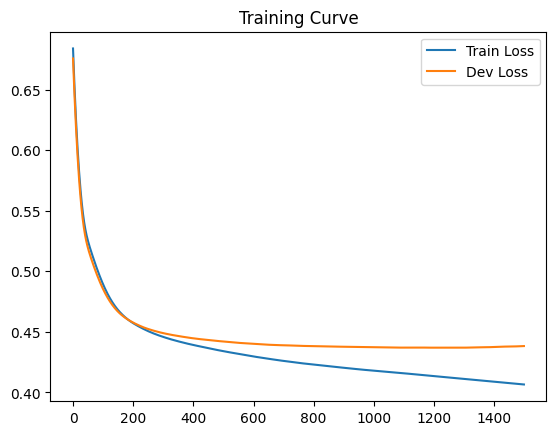

In [60]:
X_train_tensor = X_train_tensor.float()
y_train_tensor = y_train_tensor.float()
X_dev_tensor = X_dev_tensor.float()
y_dev_tensor = y_dev_tensor.float()

num_epochs = 1500 # Same iteration with our scratched version.
train_losses = []
dev_losses = []

for epoch in range(num_epochs):
    # Forward
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    # Backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step() # update parameter

    # record loss
    train_losses.append(loss.item())

    # record dev loss
    with torch.no_grad():
        dev_outputs = model(X_dev_tensor)
        dev_loss = criterion(dev_outputs, y_dev_tensor)
        dev_losses.append(dev_loss.item())

    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Dev Loss: {dev_loss.item():.4f}')

import matplotlib.pyplot as plt
plt.plot(train_losses, label='Train Loss')
plt.plot(dev_losses, label='Dev Loss')
plt.legend()
plt.title("Training Curve")
plt.show()

### Step 6: Evaluation

In [61]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

model.eval()

with torch.no_grad():
    y_pred_probs = model(X_test_tensor)
    # Round predicted probability
    y_pred_classes = (y_pred_probs > 0.5).float()

y_pred_np = y_pred_classes.cpu().numpy()
y_test_np = y_test_tensor.cpu().numpy()

print("--- Test Results ---")
test_acc = accuracy_score(y_test_np, y_pred_np)
print(f"Accuracy: {test_acc*100:.2f}%")
print(f"Classification Report:")
print(classification_report(y_test_np, y_pred_np, target_names=['No Default', 'Default']))

--- Test Results ---
Accuracy: 81.42%
Classification Report:
              precision    recall  f1-score   support

  No Default       0.84      0.94      0.89      4687
     Default       0.63      0.36      0.46      1313

    accuracy                           0.81      6000
   macro avg       0.74      0.65      0.67      6000
weighted avg       0.79      0.81      0.79      6000



## Task 3

- I chose 64 neurons for the hidden layer.
- This is a natural choose because a common rule of thumb is to choose a hiddent layer size bwteen the input and output size. I guess 64 would provides sufficient capacity for network and it won't be to large. Our input dimension is 23, so it makes sense.

- I chose 0.001 learning rate by experiments
- If I chose 0.01, the curve plot is extremely unstable, caused the loss to oscillate especially for validation (dev) dataset, and has lower accuracy compare to 0.001. And 0.001 learning rate provided a smooth, steady decrease in the loss curve. See figure below:

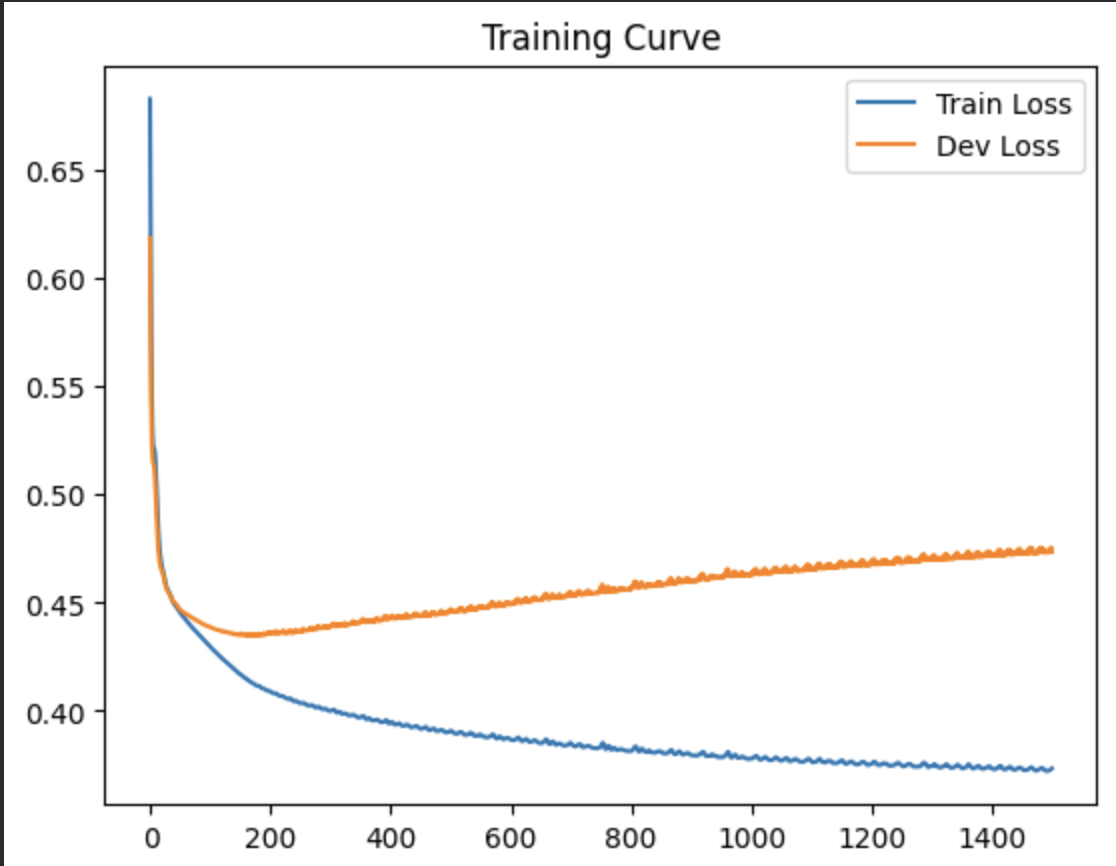

- I haven't use any regularization or dropout in final model.
- Model is simple, my model is just a 2-layer network. Shallow networks are naturally have lower risk in overfitting.

- I used Adam optimzer instead of normal SGD
- unlike SGD where a fixed learning rate is applied to all parameters, the Adam computes adaptive for each.
- Adam also combines Momentum, leading faster convergence speed.